<h2><center> Welcome to the Monthly Insurance Claim Prediction Challenge Starter Notebook</h2></center>
<figure>
<center><img src ="https://drive.google.com/uc?export=view&id=18IZFQ9-HParnXoXKSKQQWDWUsamprUk5" width = "750" height = '500'/>

*About the problem*
> Short-term insurance claims are one of the largest costs in the insurance industry, and are extremely difficult to forecast. Zimnat Insurance wants to predict the value of future claims per client, in order to better forecast annual costs.

*The objective of this challenge is*:
> To create a machine learning model to predict how much a client will claim from Zimnat per month for a whole year. 

The solution will aid Zimnat in being better prepared to address claims that are submitted, and improve customer satisfaction by alerting clients to possible claims they will make in the future. 



## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Missing values and duplicates](#Missing)
5. [Outliers](#Outliers)
6. [Dataset datatypes](#Datatypes)
7. [Feature engineering](#Engineering)
8. [Date features EDA](#Dates)
9. [Branch features EDA](#Branch)
10. [Categorical features](#Categorical)
11. [Preprocess test dataset](#Preprocess)
12. [Modelling](#Modelling)
13. [Making predictions of the test set and creating a submission file](#Predictions)
14. [More Tips](#Tips)

<a name="Libraries"></a>
## 1. Importing libraries


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
pd.options.display.float_format = '{:.5f}'.format

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# for math and statistics
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#for missing numbers
import missingno as msno


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a name="Data"></a>
## 2. Loading data

In [2]:
# Load files
train = pd.read_csv('train.csv')
policies = pd.read_csv('policies.csv')
test = pd.read_csv('test.csv')
samplesubmission = pd.read_csv('SampleSubmission.csv')

# Preview train dataset
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,300000.00000,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,rf0001,pc0007,sc00022,br00006,82150.00000
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,16000.00000,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,rf0001,pc0007,sc00023,br00002,3780.24000
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,3000.00000,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,rf0001,pc0007,sc00024,br00002,2196.50000
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,6000.00000,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,rf0001,pc0007,sc00021,br00001,105.67000
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,26850.00000,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,1605.64000


In [3]:
# Preview policies dataset
policies.head()

,policy_number,product_code,trans_date,from_date,to_date,agent,class_of_business,client_type,renewal_frequency,branch
0,pol000006995,prod00033,2017-07-01 08:24:55.800,2017-07-01 00:00:00.000,2018-07-01 00:00:00.000,ag00005,cob00035,ct0001,rf0002,br00002
1,pol000009828,prod00005,2017-07-01 09:04:02.217,2017-07-03 00:00:00.000,2017-11-02 00:00:00.000,ag00226,cob00009,ct0003,rf0001,br00006
2,pol000009828,prod00005,2017-07-01 09:04:02.217,2017-07-03 00:00:00.000,2017-11-02 00:00:00.000,ag00226,cob00031,ct0003,rf0001,br00006
3,pol000007729,prod00005,2017-07-01 09:36:53.843,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000,ag00005,cob00031,ct0003,rf0001,br00002
4,pol000007729,prod00005,2017-07-01 09:36:53.843,2017-07-01 00:00:00.000,2017-10-31 00:00:00.000,ag00005,cob00009,ct0003,rf0001,br00002


In [4]:
# Preview test dataset
test.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch
0,ID_4RO0KZI9BBW2,pol000007115,claim0005757,300000.00000,prod00005,ag00068,cob00009,rt00032,2021-03-11,ct0003,rf0001,pc0007,sc00029,br00004
1,ID_GTE9ZUJ9GZ97,pol000006008,claim0003037,2700000.00000,prod00015,ag00064,cob00034,rt00023,2020-06-25,ct0001,rf0003,pc0007,sc00022,br00002
2,ID_RUVIYRKWZ4RG,pol000007651,claim0006507,4071352.00000,prod00012,ag00021,cob00016,rt00015,2019-03-14,ct0001,rf0001,pc0011,sc00049,br00001
3,ID_J81X8SWU6JYN,pol000010981,claim0013636,0.00000,prod00002,ag00037,cob00002,rt00002,2018-12-04,ct0001,rf0002,pc0002,sc00012,br00005
4,ID_94NM3JJAWWOQ,pol000005926,claim0001750,1607178.00000,prod00015,ag00037,cob00034,rt00023,2019-09-18,ct0001,rf0003,pc0007,sc00022,br00002


In [5]:
# Preview sample submission file
samplesubmission.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,0
1,ID_GTE9ZUJ9GZ97,0
2,ID_RUVIYRKWZ4RG,0
3,ID_J81X8SWU6JYN,0
4,ID_94NM3JJAWWOQ,0


In [6]:
# Check size and shape of datasets
train.shape, policies.shape, test.shape, samplesubmission.shape

((9376, 15), (30371, 10), (4019, 14), (4019, 2))

<a name="Statistics"></a>
## 3. Statistical summaries

In [7]:
# Train statistical summary
train.describe(include = 'all')

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
count,9376,9290,9376,9376.00000,9376,9376,9376,9376,9376,9376,9376,9376,9376,9376,9376.00000
unique,9376,4076,9167,nan,37,8,37,50,1359,3,5,21,74,11,nan
top,ID_ZL2QAQMI7ZCZ,pol000006026,claim0001351,nan,prod00015,ag00037,cob00034,rt00023,2019-08-20,ct0001,rf0002,pc0007,sc00023,br00002,nan
freq,1,254,3,nan,4411,3114,3608,3771,83,6096,4853,7396,2980,3900,nan
mean,NaN,NaN,NaN,8534789.61723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41464.71125
std,NaN,NaN,NaN,112556487.28996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208434.71755
min,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
25%,NaN,NaN,NaN,6500.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.92500
50%,NaN,NaN,NaN,50542.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1956.92500
75%,NaN,NaN,NaN,420000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12700.64250


From the above statistical summary, we can deduce some of the following insights:
 - The minimum amount claimed is 0 and the maximum is 7868590.62000
 - There are 11 different branches
 - Majority of the training features are categorical in nature

In [8]:
# Policies statistical summary
policies.describe(include = 'all', datetime_is_numeric=True)

,policy_number,product_code,trans_date,from_date,to_date,agent,class_of_business,client_type,renewal_frequency,branch
count,30371,30371,30371,30371,30371,30371,30325,30371,30371,30371
unique,5217,37,20836,1431,1369,223,37,3,5,11
top,pol000005951,prod00005,2020-07-01 08:45:55.653,2018-02-01 00:00:00.000,2019-01-31 00:00:00.000,ag00226,cob00031,ct0001,rf0001,br00002
freq,174,9994,14,1122,1463,4620,7755,16747,14184,13636


<a name="Missing"></a>
## 4. Missing values and duplicates

In [9]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any(), policies.isnull().sum().any()

(True, True, True)

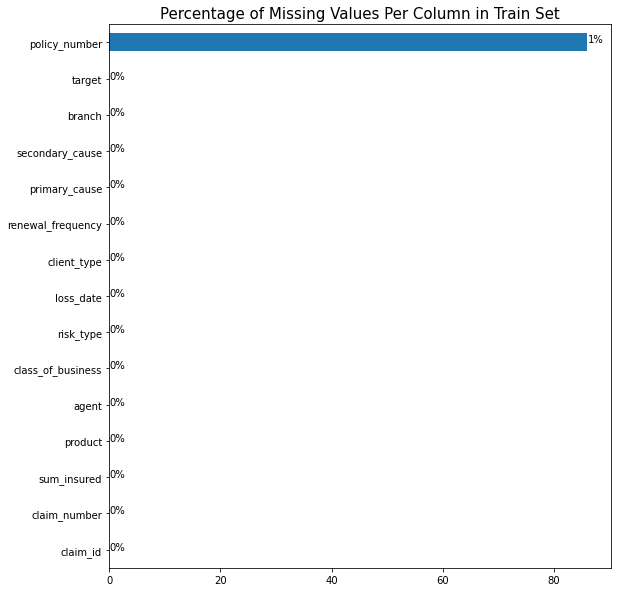

In [10]:
# Plot missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values

In [11]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any(), policies.duplicated().any()

(False, False, False)

<a name="Outliers"></a>
## 5. Outliers

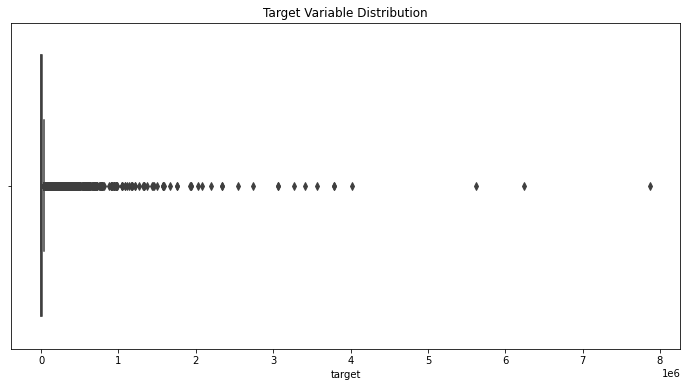

In [12]:
# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(train.target)
plt.title('Target Variable Distribution');

Outliers are those data points which differs significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...


<a name="Datatypes"></a>
## 6. Dataset datatypes

In [13]:
# Train dataset datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   claim_id           9376 non-null   object 
 1   policy_number      9290 non-null   object 
 2   claim_number       9376 non-null   object 
 3   sum_insured        9376 non-null   float64
 4   product            9376 non-null   object 
 5   agent              9376 non-null   object 
 6   class_of_business  9376 non-null   object 
 7   risk_type          9376 non-null   object 
 8   loss_date          9376 non-null   object 
 9   client_type        9376 non-null   object 
 10  renewal_frequency  9376 non-null   object 
 11  primary_cause      9376 non-null   object 
 12  secondary_cause    9376 non-null   object 
 13  branch             9376 non-null   object 
 14  target             9376 non-null   float64
dtypes: float64(2), object(13)
memory usage: 1.1+ MB


In [14]:
# Convert datetime variables to datetime objects
train.loss_date = pd.to_datetime(train.loss_date, errors='coerce')

# Confirm that the dates have been converted successfully 
train.loss_date.describe()

count                    9376
unique                   1359
top       2019-08-20 00:00:00
freq                       83
first     2018-01-01 00:00:00
last      2021-10-22 00:00:00
Name: loss_date, dtype: object

In [15]:
# Convert categorical variables to categorical objects
cat_cols = train.columns.difference(['claim_id', 'loss_date', 'sum_insured', 'target']).tolist()

# Preview categorical variables
train[cat_cols].head()

,agent,branch,claim_number,class_of_business,client_type,policy_number,primary_cause,product,renewal_frequency,risk_type,secondary_cause
0,ag00068,br00006,claim0011359,cob00031,ct0003,pol000009680,pc0007,prod00027,rf0001,rt00006,sc00022
1,ag00226,br00002,claim0005272,cob00010,ct0003,pol000006869,pc0007,prod00005,rf0001,rt00032,sc00023
2,ag00037,br00002,claim0004147,cob00010,ct0003,pol000006135,pc0007,prod00029,rf0001,rt00026,sc00024
3,ag00037,br00001,claim0009962,cob00009,ct0003,pol000008991,pc0007,prod00005,rf0001,rt00032,sc00021
4,ag00226,br00001,claim0007346,cob00034,ct0001,pol000007768,pc0007,prod00015,rf0001,rt00023,sc00021


In [16]:
# Fill in missing values in categorical variables with the most common
train[cat_cols] = train[cat_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols:
  train[col] = train[col].astype('category')

# Confirm
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   claim_id           9376 non-null   object        
 1   policy_number      9376 non-null   category      
 2   claim_number       9376 non-null   category      
 3   sum_insured        9376 non-null   float64       
 4   product            9376 non-null   category      
 5   agent              9376 non-null   category      
 6   class_of_business  9376 non-null   category      
 7   risk_type          9376 non-null   category      
 8   loss_date          9376 non-null   datetime64[ns]
 9   client_type        9376 non-null   category      
 10  renewal_frequency  9376 non-null   category      
 11  primary_cause      9376 non-null   category      
 12  secondary_cause    9376 non-null   category      
 13  branch             9376 non-null   category      
 14  target  

<a name="Engineering"></a>
## 7. Feature engineering

In [17]:
# Extract day, month and year from the loss date column
# day
train['loss_date_day'] = train.loss_date.dt.day

# month
train['loss_date_month'] = train.loss_date.dt.month
 
# year
train['loss_date_year'] = train.loss_date.dt.year

# Preview engineered date features
train[['loss_date', 'loss_date_day', 'loss_date_month', 'loss_date_year']].head()

,loss_date,loss_date_day,loss_date_month,loss_date_year
0,2021-05-13,13,5,2021
1,2018-05-13,13,5,2018
2,2018-08-18,18,8,2018
3,2018-12-20,20,12,2018
4,2018-11-07,7,11,2018


<a name="Dates"></a>
## 8. Date features EDA

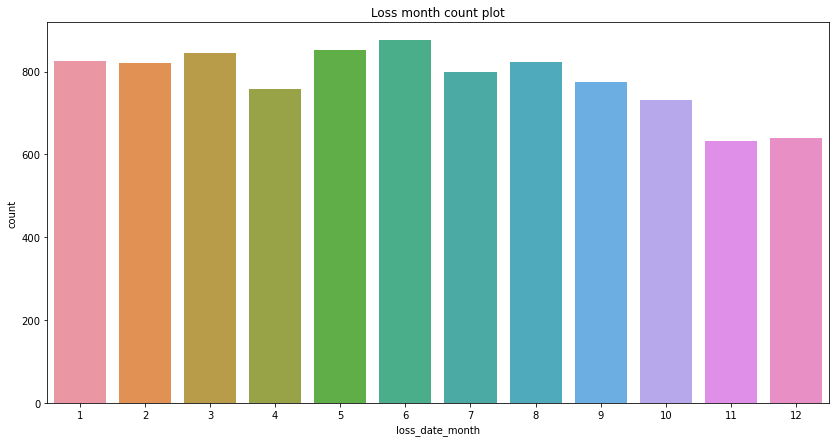

In [18]:
# Loss month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'loss_date_month', data = train)
plt.title('Loss month count plot')
plt.show()

- June has the highest number of claims and December has the least number of claims

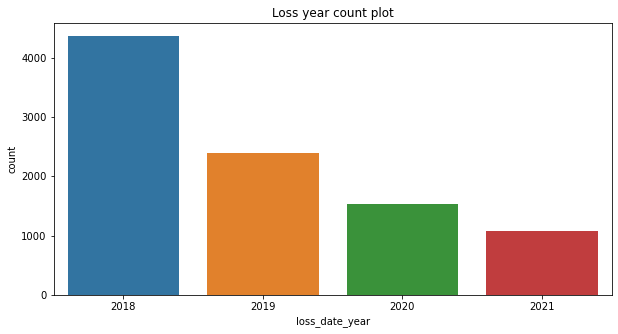

In [19]:
# Loss year countplot
plt.figure(figsize = (10, 5))
sns.countplot(x = 'loss_date_year', data = train)
plt.title('Loss year count plot')
plt.show()

- Most of the claims were done in the year 2018 and the least in the year 2021

<a name="Branch"></a>
## 9. Branch features EDA

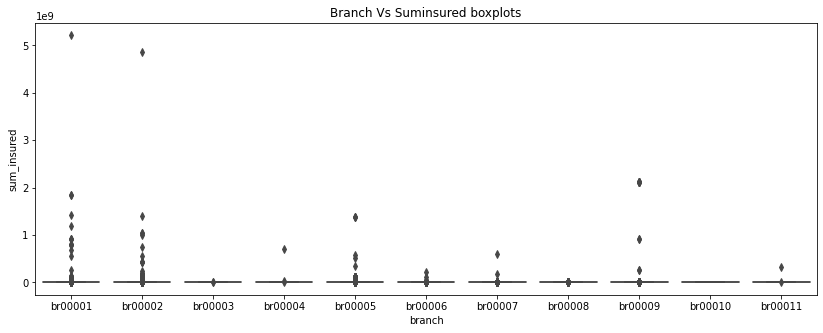

In [20]:
plt.figure(figsize = (14, 5))
sns.boxplot(x = 'branch', y = 'sum_insured', data = train)
plt.title('Branch Vs Suminsured boxplots')
plt.show()

- Branch 1 and 2 seem to have the highest number of outliers in the sum insured variable.
- This outliers might affect model performance, so its best to handle them

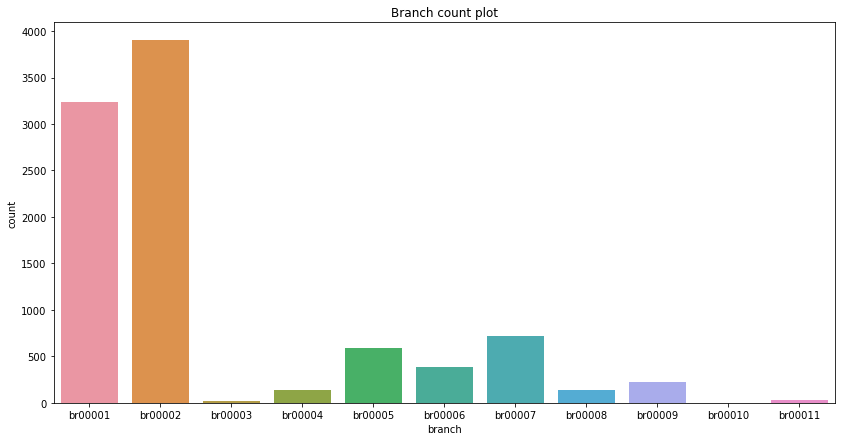

In [21]:
# Branch countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'branch', data = train)
plt.title('Branch count plot')
plt.show()

 - Most of the claims are concentrated in branch1 and branch2, so when modelling and creating new features, try to balance out the features to avoid overfitting

<a name="Categorical"></a>
## 10. Categorical features
*Try different strategies of dealing with categorical variables*
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [22]:
# Label encode categorical variables
for col in cat_cols:
  # Instantiate Labelencoder
  le = LabelEncoder()
  train[col] = le.fit_transform(train[col])

# Preview engineered train dataset
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target,loss_date_day,loss_date_month,loss_date_year
0,ID_JZ7QWRHH57RO,3070,7439,300000.00000,26,4,30,5,2021-05-13,2,0,6,20,5,82150.00000,13,5,2021
1,ID_KQ5TJMVLJ4EP,1126,3469,16000.00000,4,7,9,31,2018-05-13,2,0,6,21,1,3780.24000,13,5,2018
2,ID_NYHI7WJGGIAE,630,2799,3000.00000,28,1,9,25,2018-08-18,2,0,6,22,1,2196.50000,18,8,2018
3,ID_ROMMDCXYUXN5,2546,6448,6000.00000,4,1,8,31,2018-12-20,2,0,6,19,0,105.67000,20,12,2018
4,ID_2OTD9NX8L73D,1767,4832,26850.00000,14,7,32,22,2018-11-07,0,0,6,19,0,1605.64000,7,11,2018


<a name="Preprocess"></a>
## 11.  Preprocess test dataset

In [23]:
# Convert datetime variables to datetime objects
test.loss_date = pd.to_datetime(test.loss_date, errors='coerce')

# Fill in missing values in categorical variables with the most common
test[cat_cols] = test[cat_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols:
  test[col] = test[col].astype('category')

# Extract day, month and year from the loss date column
test['loss_date_day'] = test.loss_date.dt.day #day

test['loss_date_month'] = test.loss_date.dt.month #month
 
test['loss_date_year'] = test.loss_date.dt.year #year

# Label encode categorical variables
for col in cat_cols:
  # Instantiate Labelencoder
  le = LabelEncoder()
  test[col] = le.fit_transform(test[col])

# Preview engineered test dataset
test.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,loss_date_day,loss_date_month,loss_date_year
0,ID_4RO0KZI9BBW2,739,1667,300000.00000,4,4,8,29,2021-03-11,2,0,6,26,3,11,3,2021
1,ID_GTE9ZUJ9GZ97,312,883,2700000.00000,12,3,28,20,2020-06-25,0,2,6,20,1,25,6,2020
2,ID_RUVIYRKWZ4RG,917,1895,4071352.00000,10,0,14,14,2019-03-14,0,0,9,43,0,14,3,2019
3,ID_J81X8SWU6JYN,2081,3852,0.00000,1,1,1,1,2018-12-04,0,1,1,10,4,4,12,2018
4,ID_94NM3JJAWWOQ,257,507,1607178.00000,12,1,28,20,2019-09-18,0,2,6,20,1,18,9,2019


<a name="Modelling"></a>
## 12.  Modelling

In [24]:
lgbm = LGBMRegressor(learning_rate=0.01,num_iterations=1500,max_depth=4 ,num_leaves=150,
                              max_bins=85,min_data_in_leaf=30,reg_lambda=75)
log_lgbm = TransformedTargetRegressor(lgbm, func = np.log1p, inverse_func = np.expm1)

In [25]:
# Select main columns to be used in training
main_cols = train.columns.difference(['claim_id', 'loss_date', 'target']).tolist()
X = train[main_cols]
y = train.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

# Train model
model = BaggingRegressor(log_lgbm, n_estimators=500, max_samples=5000, bootstrap=True, n_jobs=-1, random_state=800)
model.fit(X_train, y_train)

# Make prediction
y_pred = model.predict(X_test)

# Check the MAE score of the model
print(f'LinearRegression MAE score on the X_test is: {mean_absolute_error(y_test, y_pred)}')

LinearRegression MAE score on the X_test is: 34678.19358678936


<a name="Predictions"></a>
## 13. Making predictions of the test set and creating a submission file

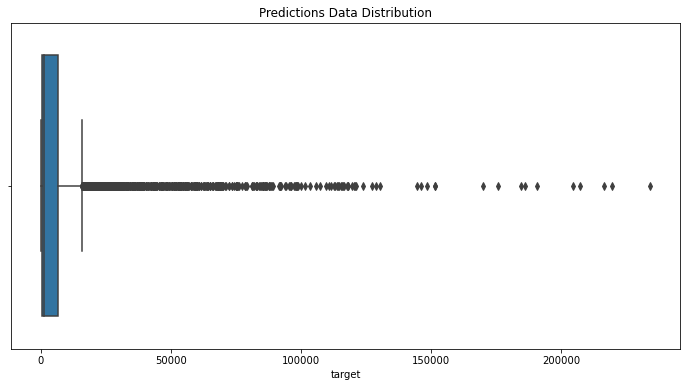

In [26]:
# Make prediction on the test set
test_df = test[main_cols]
predictions = model.predict(test_df)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.target = predictions

# Check the distribution of your predictions
plt.figure(figsize=(12, 6))
sns.boxplot(sub_file.target)
plt.title('Predictions Data Distribution');

 - There are some outliers in our predictions. 
 - More inspection/data preprocessing is needed

In [27]:
# Preview the sub_file
sub_file.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,85176.55063
1,ID_GTE9ZUJ9GZ97,16608.07346
2,ID_RUVIYRKWZ4RG,1359.05920
3,ID_J81X8SWU6JYN,361.76244
4,ID_94NM3JJAWWOQ,2145.24406


In [28]:
# Write to csv file to submit to Zindi
sub_file.to_csv("Baselin.csv", index = False)

<a name="Tips"></a>
## 1. More Tips
- Use more data - policies data
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Ensembl4ing of models 
- Cross-validation: Group folds, Stratified...

# ******************* HAPPY HACKING ***************************